Define arbitrary modulo (later called $M$), the initial state and number of precision qubits for the first chapter (later called $n_p$). The number of state qubits $n$ results from the modulo as the number of qubits needed to contain $M-1$. Because of the large circuits and state analysis, this notebook is only functional for small modulo.

In [34]:
from math import ceil, log2
import numpy as np

# global variables
modulo = 11
initial_state = 3
num_precision_qubits = 2

if modulo == 1:
    num_state_qubits = 1
else:
    num_state_qubits = ceil(log2(modulo))

# real circuit depth
def recursive_depth(circuit, d=30):
    for _ in range(d):
        circuit = circuit.decompose()
    return circuit.depth()

# simple binary representation of floats 
def bin_repr(x, max_bits = 16, pad_bits=0):
    repr = ""
    if x < 0:
        repr = "-"
    
    repr += bin(int(x))[2:]
    x -= int(x)
    
    if pad_bits > len(repr):
        repr = "0" * (pad_bits - len(repr)) + repr
    
    if x == 0:
        return repr
    
    repr += "."
    while x > 0 and max_bits > 0:
        x *= 2
        repr += str(int(x))
        max_bits -= 1
        x -= int(x)
    return repr

# plot setup
import matplotlib.pyplot as plt
plt.rcParams['text.usetex'] = True

# qiskit setup
from qiskit import Aer, transpile, execute, QuantumCircuit, QuantumRegister, AncillaRegister, ClassicalRegister
from qiskit.visualization import plot_histogram
backend_sim = Aer.get_backend('qasm_simulator')

# 1. QFT for arbitrary moduli

The quantum fourier transform for an arbitrary moduli $M\in \mathbb{N^+}$, as proposed by Kitaev in [Quantum measurements and the Abelian Stabilizer Problem (1995)](https://arxiv.org/abs/quant-ph/9511026), consists of fourier state creation and uncomputation via phase estimation. The are number of qubits necessary for storing the fourier transformed state is the same as storing the original state, $n=\max(\lceil \log_2 M \rceil,1)$. 

## 1.1 Fourier State Creation
The fourier state is created from an uniform distribution over $M$ states, $UniDist(M)$. Given the initial state $|s\rangle, s\in\mathbb{N^0}, s<M$ with $s = (s_{n-1} \dots s_0)_2$ each state $|j\rangle$ with $j = (j_{n-1} \dots j_0)_2$ of the superposition is given the phase $\exp(2\pi i \frac{s j}{M}) = \prod_{r,l<n}\exp(2\pi i \frac{s_r j_l 2^{r+l}}{M})$ using CRZ gates controlled by $|s\rangle$ and acting on $|j\rangle$: $\bigotimes_{r,l<n} C_r RZ_l(2\pi i \frac{2^{r+l}}{M}))$. The resulting circuit performs $FSC(M)|s\rangle \otimes |0\rangle^n \otimes |0\rangle^{n-q} =|s\rangle \otimes \left( \bigotimes_{j<n} \exp(2\pi i \frac{sj}{M})|j\rangle \right) \otimes |0\rangle^{n-q} = |s\rangle \otimes |\hat s_M\rangle \otimes |0\rangle^{n-q}$, with the ancillas necessary for preparing the distribution and $q$ the lowest set bit of $M=(M_n M_{n-1} \dots M_q 0 \dots 0)_2$. There are $\mathcal{O}(n^2)$ $CRZ$ gates neccessary to create the correct phase and these gates can be nested by applying $\{C_r RZ_l | r,l \in \mathbb {N^0} \land r,l<n \land r+l=t\}$ at time $t\in \mathbb{N^0}$, resulting in $depth=n+n-1$ for the phase rotations. Because of this, the circuit has $size(FSC(M))=\mathcal{O}(n^2)$ and $depth(FSC(M))=\mathcal{O}(n)$.

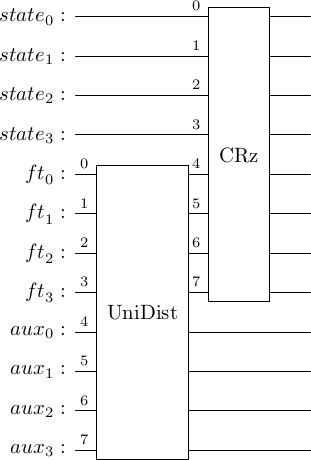

In [35]:
from library.qft import FSC

FSC(modulo).decompose().draw(fold=-1)

## 1.2 Fourier Phase Estimation

The circuits implements fourier phase estimation, as proposed by Kitaev in [Quantum measurements and the Abelian Stabilizer Problem (1995)](https://arxiv.org/abs/quant-ph/9511026). The phase estimation is composed of Hadamard gates on the first register (labelled $state$, with size $n+n_p$, where $n_p$ are additional precision qubits) followed by inverted controlled modular additions of summands $a_k = 2^k \text{ mod } M, k\in\mathbb{N^0}, k< n+n_p$ on a fourier state over the same modulus in the second register (callabelled $ft$). 

Each controlled modular addition $CtrlAdd(a)_{\text{mod } M}$ is build from four steps:
1. controlled constant addition ($+a$)
2. integer comparision ($>=M$)
3. controlled substraction ($-M$)
4. controlled integer comparision ($>a$) to uncompute the previous comparision. 

The carry-out of the addition and the comparison result require $1$ additional qubit each, the controlled constant adiition needs at most $n$ ancillas, all other steps exactly $n$.
The subcircuit performs $CtrlAdd(a)_{\text{mod } M} |ctrl\rangle \otimes |b\rangle \otimes |0\rangle^{n+2} =  |ctrl\rangle \otimes |b + ctrl \cdot a \text{ mod } M\rangle \otimes |0\rangle^{n+2}$ with $b\in\mathbb{N^0}, b<M$ being the value in the fourier register. Each of the steps has $size=\mathcal{O(n)}$ and $depth=\mathcal{O(n)}$, so the subcircuit has $size(CtrlAdd(a)_{\text{mod } M})=\mathcal{O(n)}$ and $depth(CtrlAdd(a)_{\text{mod } M})=\mathcal{O(n)}$,

In order to perform a proper modulo operation the resulting sum with the fourier state in the first step requires $max(a_k + b) < 2M \Rightarrow a_k \leq M$, so that one substraction (step 3) suffices. Some summands can be grouped s.t. $\exist K: |K|>1, a_K \coloneqq \sum_{k\in K} a_k \leq M$, then the first and last step act on the previously accumulated summand register containing $a_K$, which is non-constant but does not need controls. In the implementation the optimized groups are approximated with the classical first-fit-decreasing algorithm for the bin packing problem in $\mathcal{O}(n \log_2 n)$ time. The first grouped sum is $a_K = \sum_{k<n-1} a_k$, the first $n-1$ qubits in the $state$ register, for all other groups $a_K$ must be accumulated out-of-place first, requiring an additional $n$ qubits at most. Since $n_p +1$ additional summands are left which have to be either added alone or accumulated with one controlled adder each, the combined size and depth of all controlled modular additions are $size=\mathcal{O(n \cdot n_p)}$ and $depth=\mathcal{O(n \cdot n_p)}$.

If the fourier transform is over an intial state $|s\rangle$ the resulting phase shift of a controlled modular addition is (ignoring all additonal ancillas and register sizes):  
$CtrlAdd(a)_{\text{mod } M} |\hat s_M\rangle
= \frac{1}{\sqrt{M}} \sum_{j<M} \exp(2\pi i \frac{s j}{M}) CtrlAdd(a)_{\text{mod } M}|j\rangle
= \frac{1}{\sqrt{M}} \sum_{j<M} \exp(2\pi i \frac{s j}{M}) |j + a \text{ mod } M\rangle 
= \frac{1}{\sqrt{M}} \sum_{j<M} \exp(2\pi i \frac{s (j-a)}{M})|j\rangle 
= \exp(-2\pi i \frac{sa}{M}) |\hat s_M\rangle$. 
The inverse of the unitary operator $(CtrlAdd(a)_{\text{mod } M})^{\dagger}$ results in a positive phase shift. 
With the addition $a_k$ controlled by the $k$-th qubit of the first register the resulting state is 
$ \bigotimes_{k<n} (|0\rangle + \exp(2\pi i \cdot 2^k \frac{s}{M})|1\rangle)/\sqrt{2}
= \frac{1}{\sqrt{2^n}}\sum_{l<2^n} \exp(2\pi i \cdot l \frac{s}{M})|l\rangle$. 
Applying the inverse fourier transformation (qiskit [QFT](https://qiskit.org/documentation/stubs/qiskit.circuit.library.QFT.html)) yields 
$\frac{1}{2^n} \sum_{q,k<2^n} \exp(-2\pi i \cdot l \frac{q-2^n s/M}{2^n})$. With the approximate binary representation of the fraction $\theta := \frac{s}{M} \approx \lfloor 2^n\theta \rfloor / 2^n = (0.\theta_{n-1}\dots\theta_{0})_2 =: \theta'$, the measurement of the state results in $|2^n\theta'\rangle$ with probability $Pr(2^n\theta')\geq \frac{4}{\pi} \approx 0.4$. Increasing the number of qubits by including additional precision qubits $n_p=\mathcal{O}(\log{1/\epsilon})$ increases the probability to measure $\theta'$ for the $n$ most significant qubits to $Pr(2^n\theta')=1-\epsilon$. These probabilities are derived by Cleve et al. in [Quantum Algorithms Revisited (1997)](https://arxiv.org/abs/quant-ph/9708016).
The complete cirucit performs $FPE(M, n_p)|0\rangle^{n+n_p} \otimes |\hat s_M\rangle \otimes |0\rangle^{n_{aux}} = |2^{n+n_p}\theta'\rangle \otimes |\hat s_M\rangle \otimes |0\rangle^{n_{aux}}$ with 

$n_{aux} = \left\{ \begin{array}{cl}
2n+2 & : \ \exists K: |K|>1 \land  K\neq\{k|k\in\mathbb{N^0}, k<n\} \\
n+2 & : \  \text{else}
\end{array} \right.$.
The final inverse quantum fourier transform modulo $2^n$ mainly consists of $k-1$ controlled rotations on the $k$-th qubit controlled all previous qubits, resulting quadratic size and depth. It only acts on the $state$ qubits, leaving $n_p$ not uncomputed qubits. Assuming $n_p<n$, the circuit has $size(FPE(M, n_p))=\mathcal{O(n^2)}$ and $depth(FPE(M, n_p))=\mathcal{O(n^2)}$. For low $n$ the size and depth of the controlled modular adders still dominate the circuit size and depth.

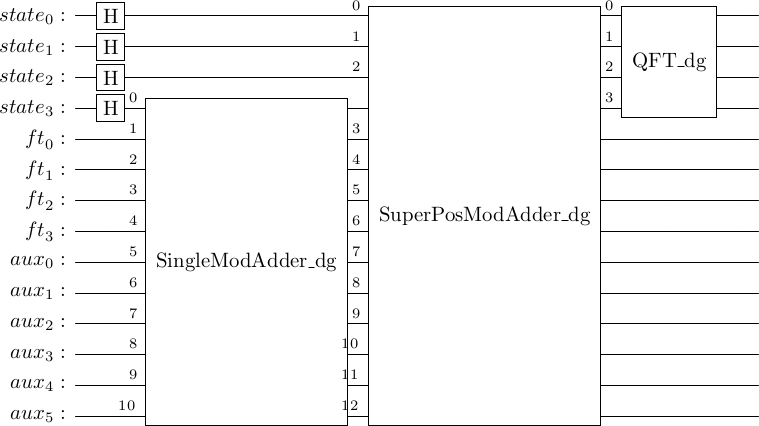

In [36]:
from library.qft import FPE

FPE(modulo, num_state_qubits=num_state_qubits).decompose().draw(fold=-1)

### 1.2.1 General State Estimation
With $FPE(M,0)$ the approximate phase $\theta'(n)$ can be estimated but only with poor probability. Increasing the probabilty for the high qubits to be correct and increasing precision of $\theta'$ requires additional qubits $n_p$, resulting in $FPE(M,n_p)$. The resulting state is multiplied with $M$ and the highest $n$ qubits containing the approimation $s' := \left\lfloor M\cdot 2^{n+n_p}\theta'(n+n_p)\right\rfloor/2^{n_p}\approx s$ are either subtracted to reduce the initial state $|s\rangle$ or applied with CNOTs on an empty register to save $|s'\rangle$ as an approximation of $|s\rangle$. For the initial state reduction the state register now contains $|s - s'\rangle \approx |0\rangle$. While the CNOTs for XOR are faster to perform, initial state uncomputation using subtraction generally yields results closer to $|0\rangle$, value wise. Because of the uncertain nature of $FPE$ and rounding errors the lowest qubits should be treated as garbage qubits. Applying the inversed multiplication and $FPE^\dagger$ uncomputes the ancilla register and the $n_p$ precision qubits. 

The multiplication by $M$ has $n+n_p$ qubits for the factor register, resulting in size and depth $\mathcal{O}((n+n_p)\cdot n_{int}')$ with $n_{int}'(M) :=num_{setbits}(M)\leq n$. The $n$ additional product qubits and $1$ ancilla add to the $FPE$ ancillas. The adder / pseudoadder with CNOT gates is of size $n$ and can use the same ancilla qubit as the multiplication. The circuit (with state reduction) performs $SE(M, n_p) |s\rangle \otimes |\hat s_M\rangle \otimes |0\rangle^{n+n_p} \otimes |0\rangle^{n_{aux}+n+1} = |s-s'\rangle \otimes |\hat s_M\rangle \otimes |0\rangle^{n+n_p} \otimes |0\rangle^{n_{aux}+n+1}$.
The circuit has $size(SE(M, n_p))=\mathcal{O(\max(n^2, (n+n_p)\cdot n_{int}'))}$ and $depth(SE(M, n_p))=\mathcal{O(\max(n^2, (n+n_p)\cdot n_{int}'))}$.

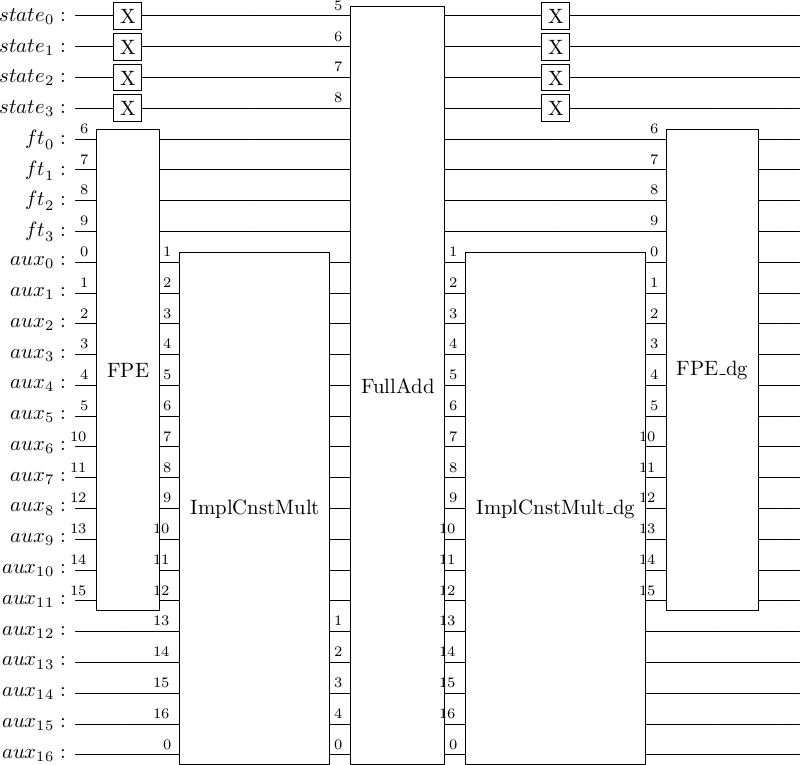

In [54]:
from library.qft import SE

SE(modulo, num_precision_qubits, uc_state_operation="sub").decompose().draw(fold=-1)

### 1.2.2 State Estimation for direct uncomputation

The depth of the previous circuit can be approximately halfed for low $n$ by multiplying the intial state with an approximation $f \approx 2^{n+n_p}/M, f \leq 2^{n+n_p}/M$. The product with any initial state $|s\rangle$ can be stored in $n + n_p$ qubits: $s \cdot f \leq (M-1) \cdot 2^{n+n_p}/M < 2^{n+n_p} - 1$. At the core part of the circuit, a single $FPE^\dagger$ is used to uncompute the approximately multiplied state $|s_f\rangle = Mult(f, n)|s\rangle$, with $Mult$ an approximate float multiplication circuit. The fourier transformed state can be represented with 
$|\hat s_f\rangle = \bigotimes_{j=0}^{n + n_p-1} (|0\rangle + e^{i \cdot \phi_{approx}(j)} |1\rangle)/\sqrt{2}$ with $\phi_{approx}(j) := 2 \pi \cdot \frac{s_f}{2^{n + n_p}} \cdot 2^j$. Using modular addtion on controlled by each qubit, the phase at each qubit is substracted by the exact phase 
$\phi_{exact}(j) = 2 \pi \cdot \frac{s}{M} \cdot 2^j$ to get 
$\Delta \phi(j) = \phi_{approx}(j) - \phi_{exact}(j)$. With an Hadamard gate following the controlled modular additions, the final state is: 
$|s''\rangle := \bigotimes_{j=0}^{n + n_p-1} H (|0\rangle + e^{i \cdot \Delta \phi(j)} |1\rangle)/\sqrt{2} 
= \bigotimes_{j=0}^{n + n_p-1} \frac{1 + e^{i \cdot \Delta \phi(j)}}{2}|0\rangle +  \frac{1 - e^{i \cdot \Delta \phi(j)}}{2} |1\rangle$.
With $\forall j: \frac{3\pi}{2} \equiv -\frac{\pi}{2} \ll \Delta \phi(j) \ll \frac{\pi}{2} \Rightarrow |s''\rangle \approx |0\rangle$.

The circuit is implemented with in-place multiplication $InPlaceMult(\lfloor f \rfloor, n)$ and out-of-place approximate float multiplication with uncomputation $CnstMult_{uncomp}(f, n)$. The in-place verision requires maximally $n$ ancillas, less than $FPE(M, n_p)$. The out-of-place version uses $n$ ancilla qubits as state qubits to store the lower product qubits (later swapped back) and uses $n-j_{float}-1$ ancillas, where $j_{float}$ is the lowest index at which the binary representation of $\lfloor 2^{n-1} f \rfloor$ has a bit set to $1$. 
The circuit performs $SEDUC |s\rangle \otimes |0\rangle^{n_p} \otimes |\hat s\rangle \otimes |0\rangle^{n'_{aux}} = |s''\rangle \otimes |\hat s\rangle \otimes |0\rangle^{n'_{aux}}$, where ancilla count is defined as 

$n'_{aux} = \left\{ \begin{array}{cl}
n_{aux} & : \ \text{in-place multiplication} \\
\max(n_{aux}, 2n-j_{float}-1) & : \ \text{out-of-place multiplication}
\end{array} \right.$. 

Because of the quantum fourier transform modulo $2^{n+n_p}$, using any multiplication with $size(Mult(f, n))=\mathcal{O((n+n_p)^2)}$ and $depth(Mult(f, n))=\mathcal{O((n+n_p)^2)}$ will result in $size(SEDUC(M, n_p))=\mathcal{O((n+n_p)^2)}$ and $depth(SEDUC(M, n_p))=\mathcal{O((n+n_p)^2)}$. For low $n$ the size and depth of $FPE(M, n_p)$ still dominate the circuit size and depth.

In-place multiplication, circuit depth=698, multiplication factor=5


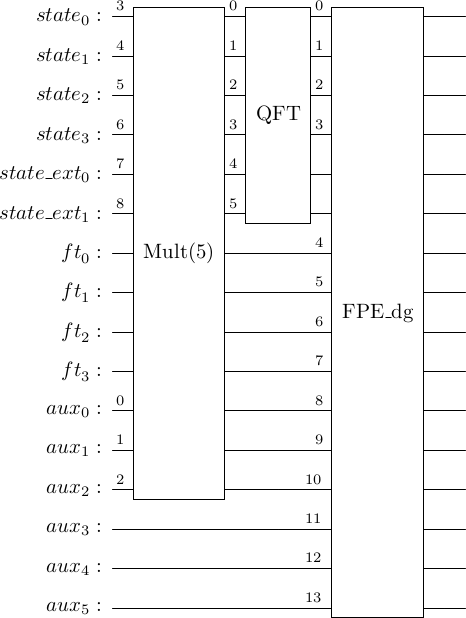

In [38]:
from library.qft import SEDirectUC

se_direct_uc1 = SEDirectUC(modulo, num_precision_qubits=num_precision_qubits, inplace_mult=True, num_garbage_qubits=num_precision_qubits)
print(f"In-place multiplication, circuit depth={recursive_depth(se_direct_uc1)}, multiplication factor={se_direct_uc1.factor}")
se_direct_uc1.decompose().draw(fold=-1)

Circuit variant with out-of-place multiplication. The multiplication uncomputes the state factor and uses ancillas for the lower product qubits, which later are swapped with the state qubits. For $s = (s_{n+n_p-1}\dots s_0)_2$ the product is $\sum_{l=0}^{n+n_p-1} s_l \cdot \lfloor 2^l \cdot 2^{n+n_p}/M \rfloor$. 

Out-of-place multiplication, circuit depth=1231, approximate multiplication factor≈5.818181818181818


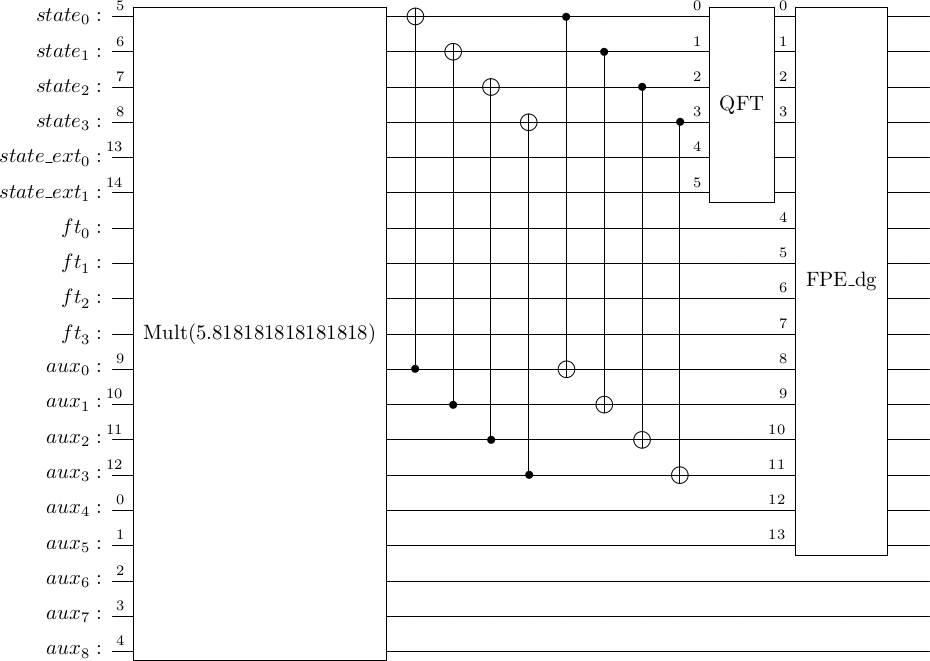

In [39]:
se_direct_uc2 = SEDirectUC(modulo, num_precision_qubits=num_precision_qubits, inplace_mult=False, num_garbage_qubits=num_precision_qubits)
print(f"Out-of-place multiplication, circuit depth={recursive_depth(se_direct_uc2)}, approximate multiplication factor≈{se_direct_uc2.factor}")
se_direct_uc2.decompose().draw(fold=-1)

## 1.3 Complete QFT
For a complete quantum fourier transform, the state register has to be (approximately) uncomputed after $FSC(M)$ with $SE(M, n_p)$ or $SEDUC(M, n_p)$, resulting in $QFT_{SE}(M, n_p)$ or $QFT_{SEDUC}(M, n_p)$. Because $FSC(M)$ is relatively small, the size, depth and ancilla requirements are determined by $SE(M, n_p)$ or $SEDUC(M, n_p)$. 

## 1.3.1 General form
With the general state estimation the circuit performs $QFT_{SE}(M, n_p) |s\rangle \otimes |0\rangle^n \otimes |0\rangle^{n+n_p} \otimes |0\rangle^{n_{aux}+n+1} = |s-s'\rangle \otimes |\hat s_M\rangle \otimes |0\rangle^{n+n_p} \otimes |0\rangle^{n_{aux}+n+1}$.
The circuit has $size(QFT_{SE}(M, n_p))=\mathcal{O(\max(n^2, (n+n_p)\cdot n_{int}'))}$ and $depth(QFT_{SE}(M, n_p))=\mathcal{O(\max(n^2, (n+n_p)\cdot n_{int}'))}$.
The depth is high for low $n$, restricting its current use.

In-place multiplication, circuit depth=3423


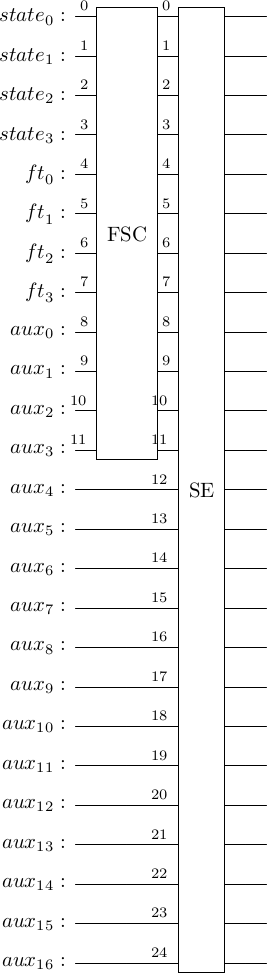

In [40]:
from library.qft import QFT

qft = QFT(modulo, num_precision_qubits=num_precision_qubits)
print(f"In-place multiplication, circuit depth={recursive_depth(qft)}")
qft.decompose().draw(fold=-1)

Mesuring the approximately uncomputed state qubits shows that the approximation is good, if the lowest qubit(s) are discarded as garbage.

Measured 'uncomputed' state qubits for modulo=11, initial_state=3, num_precision_qubits=2.


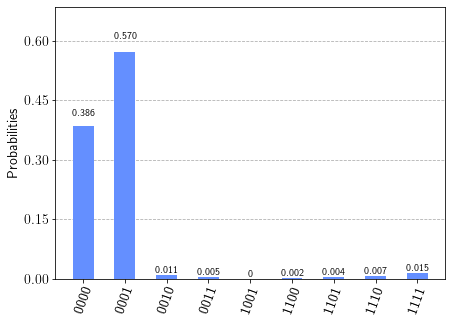

In [41]:
qc = QuantumCircuit(len(qft.qubits), name="test")
cr = ClassicalRegister(num_state_qubits)
qc.add_register(cr)

for idx, bit in enumerate(reversed(bin(initial_state)[2:])):
    if bit == "1":
        qc.x(idx)

qc.compose(qft, inplace=True)

for i in range(len(cr)):
    qc.measure(i, cr[i])

result_sim = backend_sim.run(transpile(qc, backend_sim), shots=1024).result()

print(f"Measured 'uncomputed' state qubits for modulo={modulo}, initial_state={initial_state}, num_precision_qubits={num_precision_qubits}.")
hist = plot_histogram(result_sim.get_counts())
hist.set_facecolor("white")
hist

### 1.3.1 Direct state uncomputation
For low $n$, the depth can be reduced by using the direct uncomputation variant of state estimation, with either in-/ or out-of-place multiplication. The circuit performs $QFT_{SEDUC} |s\rangle \otimes |0\rangle^{n_p + n} \otimes |0\rangle^{n'_{aux}} = |s''\rangle \otimes |\hat s\rangle \otimes |0\rangle^{n'_{aux}}$. It has $size(QFT_{SEDUC}(M, n_p))=\mathcal{O((n+n_p)^2)}$ and $depth(QFT_{SEDUC}(M, n_p))=\mathcal{O((n+n_p)^2)}$.

In-place multiplication, circuit depth=916, multiplication factor=5


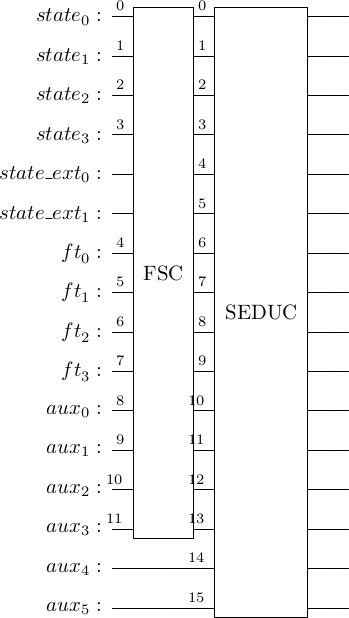

In [42]:
from library.qft import QFTDirectUC

qft_direct_uc = QFTDirectUC(modulo, num_precision_qubits=num_precision_qubits, inplace_mult=True, num_garbage_qubits=num_precision_qubits)
print(f"In-place multiplication, circuit depth={recursive_depth(qft_direct_uc)}, multiplication factor={qft_direct_uc.factor}")
qft_direct_uc.decompose().draw(fold=-1)

Mesuring the approximately uncomputed state qubits shows that the approximation is not close enough, especially for the in-place multipliction.

Measured 'uncomputed' state qubits for modulo=11, num_precision_qubits=2.


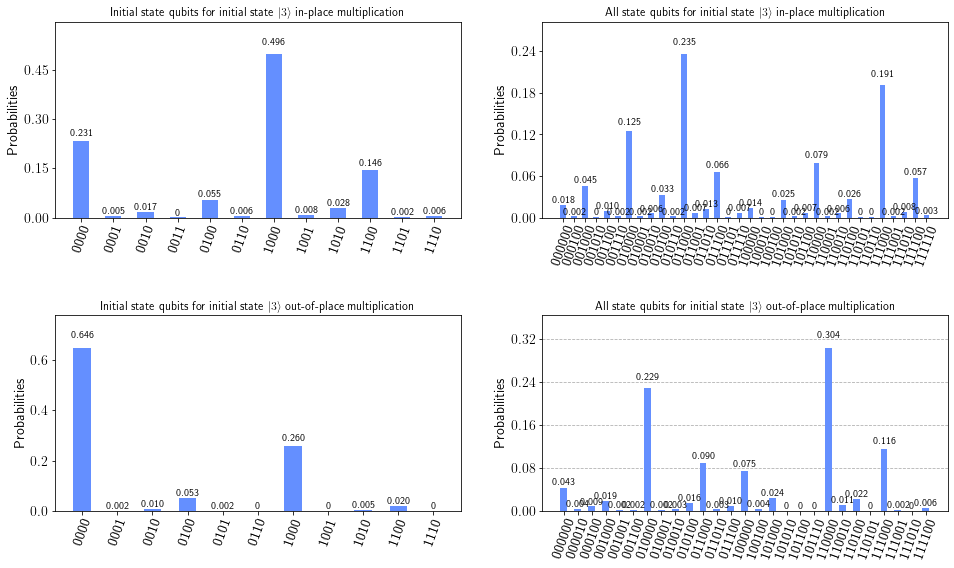

In [43]:
plt.rcParams['figure.figsize'] = [16, 9]
fig, axes = plt.subplots(nrows=2, ncols=2)
fig.subplots_adjust(hspace=0.5)

for inplace_mult in [True, False]:
    qft_direct_uc = QFTDirectUC(modulo, num_precision_qubits=num_precision_qubits, inplace_mult=inplace_mult)
    qr_state = QuantumRegister(qft_direct_uc.num_state_qubits, "state")
    regs = [qr_state]
    state_qubits = qr_state[:]
    if qft_direct_uc.num_state_ext_qubits > 0:
        qr_state_ext = QuantumRegister(qft_direct_uc.num_state_ext_qubits, "state_ext")
        regs.append(qr_state_ext)
        state_qubits += qr_state_ext[:]
    qr_ft = QuantumRegister(qft_direct_uc.num_state_qubits, "ft")
    qr_aux = QuantumRegister(qft_direct_uc.num_ancillas, "aux")
    regs += [qr_ft, qr_aux]

    aqft = QuantumCircuit(*regs, name="measured_aqft")

    for idx, bit in enumerate(reversed(bin(initial_state)[2:])):
        if bit == "1":
            aqft.x(qr_state[idx])

    aqft.compose(qft_direct_uc, aqft.qubits, inplace=True)

    for qubits, ax, title in [(qr_state[:], axes[1 - int(inplace_mult)][0], "Initial state qubits"), 
                            (state_qubits, axes[1 - int(inplace_mult)][1], "All state qubits")]:
        measured_aqft = aqft.copy()
        cr = ClassicalRegister(len(qubits))
        measured_aqft.add_register(cr)
        measured_aqft.measure(qubits, cr)
        result_sim= backend_sim.run(transpile(measured_aqft, backend_sim), shots=1024).result()
        counts = result_sim.get_counts(aqft)
        hist = plot_histogram(counts, ax=ax)
        title += f" for initial state $|{initial_state}\\rangle$"
        if inplace_mult:
            title += " in-place multiplication"
        else:
            title += " out-of-place multiplication"
        ax.set_title(title)

print(f"Measured 'uncomputed' state qubits for modulo={modulo}, num_precision_qubits={num_precision_qubits}.")
plt.show()

The following plot displays the phase difference $-\Delta \phi(j)$ = $\phi_{exact}(j) - \phi_{approx}(j)$ (mod $2\pi$) at qubit $j$ for the initial states $|s\rangle, s<min(9, M)$, with the approximated in- and out-of-place multiplications. The absolute difference tends to increase exponentially (if the the modulo is ignored) with $2^j$ (except for initial state $|s\rangle=|0\rangle$), since the approximation precision decreases by one bit for $j\to j+1$. This means that the approximation $|s_f\rangle \approx |0\rangle$ quickly fails for high $j$. The out-of-place multiplication is more precise, allowing for less deviation. The deviation increases linear with the initial state number $s$. This can be explained by comparing two $s$-values, $s_0$ and $s_k = 2^k s_0$. With $k$ bits less precision in the phase for $s_k$ compared to $s_0$, we have $\forall j \frac{\Delta \phi_{s_k}(j)}{\Delta \phi_{s_0}(j)} = \mathcal{O}(2^k)$ (if the modulo is ignored). The linear incrementation by $s$ is reset for the out-of-place-multiplication at $s$ equal a power of two, since the approximation now has one more precision qubit.
The core issue is that higher multiplication precision lessens the deviation (exponentially), but also requires more qubits, of which the most significant now have (exponentially) increased phase differences. Therefore increasing $n_p$ for uncomputing is impractical. 

Phasedifference at the j-th qubit for modulo=11, num_precision_qubits=2.
The dotted lines for the multiplications are only for visually grouping the data points and not representative of the course of the function. The phase difference is modulo 2π.


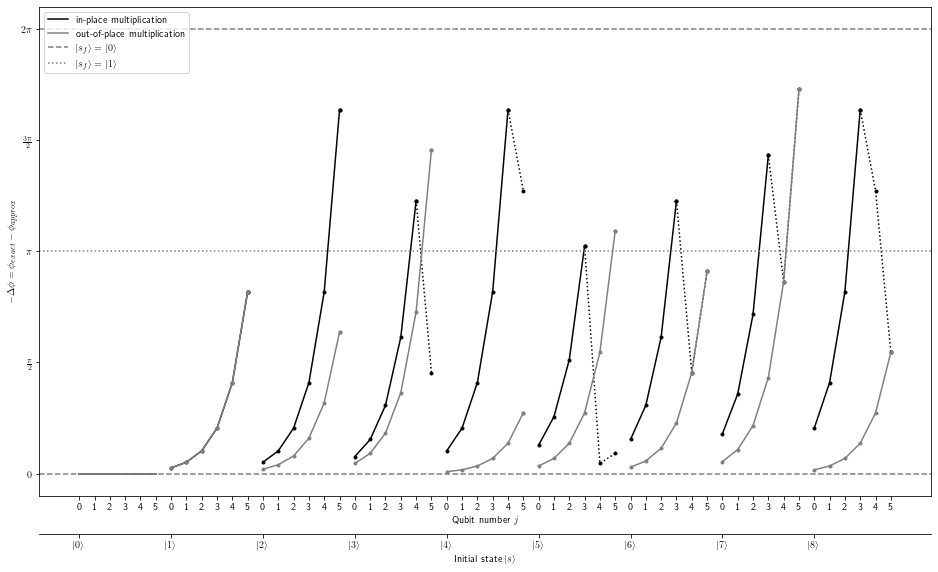

In [44]:
plt.rcParams['figure.figsize'] = [16, 9]

num_state_qubits = ceil(log2(modulo))
factor = 2**(num_state_qubits + num_precision_qubits) / modulo
max_s = 8

print(f"Phasedifference at the j-th qubit for modulo={modulo}, num_precision_qubits={num_precision_qubits}.")
print("The dotted lines for the multiplications are only for visually grouping the data points and not representative of the course of the function. The phase difference is modulo 2π.")

for s in range(min(modulo, max_s + 1)):
    q_exact = s / modulo
    
    q_approx1 = s * int(factor) / 2**(num_state_qubits + num_precision_qubits)
    q_approx2 = 0
    for idx, bit in enumerate(reversed(bin(s)[2:])):
        if bit == "1":
            q_approx2 += int(factor * 2**idx)
    q_approx2 /= 2**(num_state_qubits + num_precision_qubits)
    
    diffs1 = []
    diffs2 = []
    for bit_num in range(num_state_qubits + num_precision_qubits):  
        diffs1.append((q_exact - q_approx1) % 1)
        diffs2.append((q_exact - q_approx2) % 1)
        
        q_exact *= 2
        q_exact -= int(q_exact)
        q_approx1 *= 2
        q_approx1 -= int(q_approx1)
        q_approx2 *= 2
        q_approx2 -= int(q_approx2)
    
    offset = s * (num_state_qubits + num_precision_qubits)
    x_part_range = [bit_num + offset for bit_num in range(num_state_qubits + num_precision_qubits)]
    
    if s == 0:
        labels = ("in-place multiplication", "out-of-place multiplication")
        plt.plot(x_part_range, diffs1, color="black", label=labels[0])
        plt.plot(x_part_range, diffs2, color="gray", label=labels[1])
    
    else:
        prev_diff = -1
        cutoff_idx1 = num_state_qubits + num_precision_qubits
        for idx in range(num_state_qubits + num_precision_qubits):
            if prev_diff > diffs1[idx]:
                cutoff_idx1 = idx
                break
            prev_diff = diffs1[idx] 
        
        prev_diff = -1
        cutoff_idx2 = num_state_qubits + num_precision_qubits
        for idx in range(num_state_qubits + num_precision_qubits):
            if prev_diff > diffs2[idx]:
                cutoff_idx2 = idx
                break
            prev_diff = diffs2[idx]
        
        plt.plot(x_part_range[:cutoff_idx1], diffs1[:cutoff_idx1], marker=".", color="black")
        plt.plot(x_part_range[cutoff_idx1-1:], diffs1[cutoff_idx1-1:], marker=".", color="black", ls=":")
        plt.plot(x_part_range[:cutoff_idx2], diffs2[:cutoff_idx2], marker=".", color="gray")
        plt.plot(x_part_range[cutoff_idx2-1:], diffs2[cutoff_idx2-1:], marker=".", color="gray", ls=":")
        

plt.axhline(0, color="gray", label="$|s_f\\rangle = |0\\rangle$", ls="--")
plt.axhline(0.5, color="gray", label="$|s_f\\rangle = |1\\rangle$", ls=":")
plt.axhline(1, color="gray", ls="--")

x_range = np.arange(min(modulo, max_s + 1) * (num_state_qubits + num_precision_qubits))
x_ticks = [bit_num for bit_num in range(num_state_qubits + num_precision_qubits)] * min(modulo, max_s + 1)
plt.xlabel("Qubit number $j$")
plt.xticks(x_range, x_ticks)

sec_x_ticks = [f"$|{s}\\rangle$" for s in range(min(modulo, max_s + 1))]
sec_ax = plt.gca().secondary_xaxis(-0.7 / plt.rcParams['figure.figsize'][1])
sec_ax.set_xlabel("Initial state $|s\\rangle$")
sec_ax.set_xticks(np.arange(len(sec_x_ticks))*(num_state_qubits + num_precision_qubits), sec_x_ticks)

plt.ylim(-0.05, 1.05)
plt.ylabel("$-\Delta \phi = \phi_{exact} - \phi_{approx}$")
plt.yticks([0, 0.25, 0.5, 0.75, 1], ["$0$", "$\\frac{\pi}{2}$", "$\pi$", "$\\frac{3\pi}{2}$", "$2 \pi$"])

plt.legend(loc="upper left")
plt.show()

# 2. Approximate QTF for arbitrary moduli
The AQFT proposed by Hales in [The Quantum Fourier Transform and Extensions of the Abelian Hidden Subgroup Problem (2002)](https://arxiv.org/abs/arXiv:quant-ph/0212002) allows for a functionally garbage free
quantum fourier transform for arbitrary moduli. The transformation is approximated over two simple fourier transforms (with modulo a power of two, one of them can be substituded with Hadamard Gates) and multiplication or division by known constants. 
The approximation accuracy can be increased with a parameter, but comes at a cost of increased qubit requirements and increased depth and size.  
If the circuit uses exact integer division $CnstDiv$ for the devision and  $CnstDiv^\dagger$ for the multiplication only the division remainder in the $rmd$ register is left besides the approximated transformed state, but the remainder is nearly input independent (except for the phase) and can be uncomputed.

### Proof of concept
First find an $R = 2^r$ and $N'=2^{n'}$, so that $N' \geq RM$. Starting from the inital state $|v\rangle \otimes |0\rangle = \sum_{i<M} v_i |i\rangle \otimes |0\rangle$ if follows (ignoring all ancilla qubits and register sizes)  
$I \otimes H^r: \to |v\rangle \otimes (H|0\rangle)^r 
= \sum_{i<M} v_i |i\rangle \otimes \frac{1}{\sqrt{R}}\sum_{j<R} |j\rangle$,  
$DIV(M)^{\dagger}: \to \frac{1}{\sqrt{R}}\sum_{i<M, j<R} v_i |i + jM\rangle 
=: |w\rangle = \sum_{l<RM} w_l |l\rangle$ with $w_l = \frac{v_{l\text{ mod }M}}{\sqrt{R}}$.  
For now assume $N' = RM$. With $l=:l_1 + l_2 M$ and $k=:k_1 R + k_2$ for $l_1,k_1 <M, l_2,k_2 < R$ and $\sum_{p< P} \exp(2\pi i\left(f(q) + \frac{pq}{P}\right)) = \left\{ \begin{array}{cl}
P\exp(2\pi i f(0)) & : \ q = 0 \\
0 & : \text{otherwise}
\end{array} \right.$ for $q\in\mathbb{N}^0, q<P, f:\mathbb{N}\to\mathbb{R}$ it follows  
$QFT(N'=RM): \to \frac{1}{\sqrt{RM}}\sum_{l,k<RM} w_l \exp(2\pi i\frac{lk}{RM})|k\rangle 
= \frac{1}{R\sqrt{M}}\sum_{l,k<RM} v_{l\text{ mod }M} \exp(2\pi i\frac{lk}{RM})|k\rangle 
= \frac{1}{R\sqrt{M}}\sum_{l_1,k_1<M, l_2,k_2<R} v_{(l_1 + l_2 M)\text{ mod }M} \exp(2\pi i\frac{(l_1 + l_2 M)(k_1 R + k_2)}{RM})|k_1 R + k_2\rangle$  
$= \frac{1}{R\sqrt{M}}\sum_{l_1,k_1<M, l_2,k_2<R} v_{l_1} \exp(2\pi i\left(\frac{l_1 k_1}{M} + \frac{l_1 k_2}{RM} + l_2 k_1 + \frac{l_2 k_2}{R}\right))|k_1 R + k_2\rangle
= \frac{1}{R\sqrt{M}}\sum_{l_1,k_1<M, l_2,k_2<R} v_{l_1} \exp(2\pi i\left(f_{l_1, k_1}(k_2) + 0 + \frac{l_2 k_2}{R}\right))|k_1 R + k_2\rangle
= \frac{1}{\sqrt{M}}\sum_{l_1,k_1<M} v_{l_1} \exp(2\pi i f_{l_1, k_1}(0))|k_1 R\rangle 
= \frac{1}{\sqrt{M}}\sum_{l_1,k_1<M} v_{l_1} \exp(2\pi i \frac{l_1 k_1}{M}|k_1 R\rangle 
= \frac{1}{\sqrt{M}}\sum_{l_1,k_1<M} \^v_{k_1}|k_1 R\rangle$,  
$DIV(R=\frac{N'}{M}): \to \frac{1}{\sqrt{M}}\sum_{l_1,k_1<M} \^v_{k_1}|k_1\rangle = |\^v\rangle$.  
So for $N' = RM$ the algorithm is precise. For $N' > RM$ the fourier transform over $N'$ will show smeared bumps around $|\left\lfloor f\cdot\frac{N'}{M} \right\rceil \rangle$ for $f\in \mathbb{N}^0, f < M$. The smearing is a result of the approximative nature, and is reduced by increasing the number of repetitions $R$ of the initial state $|v\rangle$. This is comparable to the classical fourier transform over periodic functions where the resulting peaks in the frequency domain sharpen for larger input intervals i.e. more repetitions.  

The parameter $\epsilon$ describes the precision of the with $\lVert |s'\rangle  - |\hat s\rangle \rVert < \epsilon$, where $|\hat s'\rangle$ is the approximated fourier transform in the $ft$ register and $|\hat s\rangle = \bigotimes_{j<n} \exp(2\pi i \frac{sj}{M})|j\rangle$ the exact fourier tranform. Hales derives $\lVert AQFT(M, \epsilon)|s\rangle  - |\hat s\rangle \rVert < \frac{4RM}{N'}+ \frac{8\log_2 M}{\sqrt{R}}$ in the paper, so the implementation uses $r = \max\left(\left\lceil 2 \cdot  \log_2\left(\frac{8 \log_2 (M)}{\epsilon}\right) \right\rceil ,1\right)$ and $n'=\max\left(\left\lceil \log_2 \left(\frac{4RM}{\epsilon}\right) \right\rceil, r + n\right)$.
All in all, the circuit includes $r$ parallel Hadamard gates leading into the dividend of an inversed division $CnstDiv(M, r+1)^\dagger$, along side the input state for the remainder. The additional qubit of $r+1$ is used as a sign qubit in the devision. The resulting multiplication is bounded by $(2^r-1)\cdot M +s \leq 2^r\cdot M -1 < 2^{r+n}$, so $r+n$ qubits storing the result suffice. The following quantum fourier transform over $2^{n'}\geq 2^{r+n}$  covers these qubits. At the end, the devision $CnstDiv(\lfloor \frac{N'}{M} \rfloor, n)$ results in $n$ fourier state qubits as the quotient and $\left\lceil(\log_2 (\lfloor \frac{N'}{M} \rfloor))\right\rceil = n'-n+1$ remainder qubits (assuming $2^{n-1}\leq M<2^n$). The last division requires the most ancilla qubits with $n'-n+2$. 
The circuit performs $AQFT(M, \epsilon)|s\rangle \otimes |0\rangle^{2n'-2n+3} = |rmd\rangle \otimes |\hat s'\rangle \otimes |0\rangle^{n'-n+2}$.
The first devision has depth and size $\mathcal{O}(n \cdot r)$, the fourier transform $\mathcal{O}(n'^2)$ and the second devision $\mathcal{O}((n'-n) \cdot n)$, so the circuit has $size(AQFT(M, \epsilon))=\mathcal{O}(n'^2)$ and $depth(AQFT(M, \epsilon))=\mathcal{O}(n'^2)$, but both are dominated by the divisions at low $n$.

Circuit depth=998


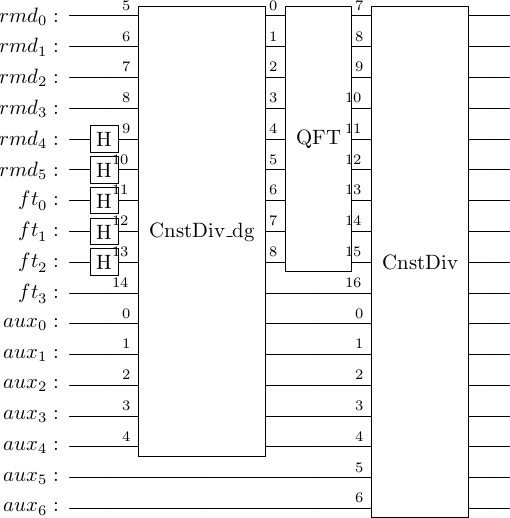

In [45]:
from library.qft import AQFT

aqft = AQFT(modulo, eps=6)
print(f"Circuit depth={recursive_depth(aqft)}")
aqft.decompose().draw(fold=-1)

## 2.1 Dealing with the Remainder
The superposition of remainders $|rmd(qt)\rangle$ for each quotient state $|qt\rangle$ are the result from the integer approximation in the divisior $Val_{dvsr} :=\left\lfloor \frac{N'}{M} \right\rfloor$ and the smear around the high-amplitudude states after the (second) fourier transform $|qt \cdot\left\lfloor \frac{N'}{M} \right\rceil \rangle$ for $qt\in \mathbb{N}^0, qt < M$. 
An approximation of the superposition including the smear to one adjacend state $|rmd(qt)\rangle \approx \alpha\left|\left\lfloor qt \cdot\left(\frac{N'}{M} - Val_{dvsr} \right) \right\rfloor \right\rangle + \beta\left| \left\lfloor qt \cdot\left(\frac{N'}{M} - Val_{dvsr} \right) \right\rfloor +1 \right\rangle$, for some $\alpha,\beta \in \mathbb{C}:|\alpha|^2 +|\beta|^2 = 1$. The phase difference between $\alpha$ and $\beta$ stems from the imperfect fourier collapse and depends on the inital state making it very hard to uncompute. In order to reduce the remainder, approximately multiply the quotient with $Val_{fct}(n_q) := 2^{n_q} \cdot\left(\frac{N'}{M} - Val_{dvsr} \right)<2^{n_q}, n_q\in \mathbb{N}$ and subtract or XOR (using CNOTs) the remainder with the high qubits of the result $p_{float} = \sum_{l<n'-n+1} \sum_{i=-l}^{n-1} Val_{{fct}_i} qt_l 2^{i+l}$, resulting in $\lfloor p_{float} / 2^{n_q} \rfloor \approx \left\lfloor qt \cdot\left(\frac{N'}{M} - Val_{dvsr} \right)\right\rfloor$.  While the CNOTs for XOR are faster to perform, initial state uncomputation using subtraction generally yields results closer to $|0\rangle$, value wise. Afterwards the multiplication is inverted to recompute the quotient. With enough precision qubits $n_q$ the resulting approximated remainder will be very small and the remaining lower qubits $n_g$ can be declared garbage qubits for $rmd<2^{n_g}$.

Using the small $FullAdd(Val_{fct}, n)$ and $ImplCnstMult(Val_{fct}, n)$ with size and depth $\mathcal{O}(n_q\cdot n)$ does not change the circuit size or depth if $n_q< n'$. With the $n_q+n$ product qubits and a single ancilla as new ancillas, the circuit performs $AQFT_{uncomp}(M, \epsilon)|s\rangle \otimes |0\rangle^{\max(2n'-2n+3, n_q+n+1)} = |rmd - p_{float}\rangle \otimes |\hat s'\rangle \otimes |0\rangle^{\max(2n'-2n+3, n_q+n+1)}$.

Circuit depth=1182


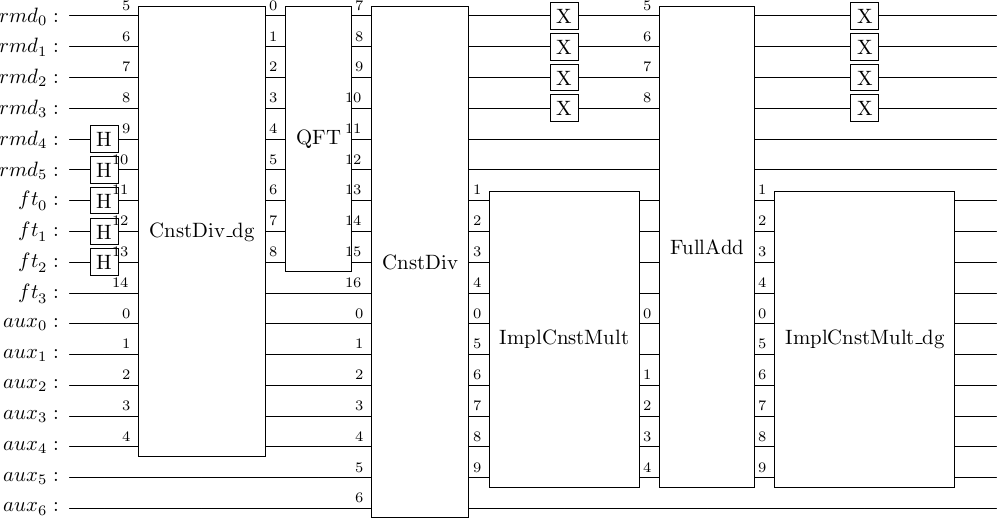

In [46]:
aqft = AQFT(modulo, uncompute_remainder=True, eps=6, num_uc_precision_qubits=1)
print(f"Circuit depth={recursive_depth(aqft)}")
aqft.decompose().draw(fold=-1)

In the following section the normal and uncomputed remainders of each output state for multiple input states are presented along with the theoretically expected remainders.

In [47]:
# must be smaller than 1/2
threshold = 1/4
# experiment config
shots = 1024
count_threshold = threshold
# example histogramm
hist_example_input = 0
if hist_example_input >= min(modulo, 8):
    raise Exception("Example input for histogramm should be smaller than min(modulo, 8)!")

# variables used by AQFT
eps = 6
small_qft = max(ceil(2 * log2(8*log2(modulo)/eps)), 1)
big_qft = max(ceil(log2(4 * 2**small_qft * modulo/eps)), num_state_qubits + small_qft)
dvsr = int(2**big_qft / modulo)

def theo_remainders():
    global modulo, big_qft, dvsr, threshold
    
    theoretical_remainders = []
    for s in range(modulo):
        remainder = s * ((2**big_qft/modulo) -dvsr)
        if (abs(round(remainder) - remainder) > threshold):
            theoretical_remainders.append([int(remainder), ceil(remainder)])
        else:
            theoretical_remainders.append([round(remainder)])
    
    return theoretical_remainders

def list_remainders(counts, num_state_qubits, order=2):
    remainders = []
    for i in range(modulo):
        rmds_dict = {}
        bin_repr = "0" * (num_state_qubits-len(bin(i)[2:])) + bin(i)[2:]
        for key in counts.keys():
            if key[:num_state_qubits] == bin_repr:
                rmds_dict[int(key[num_state_qubits:], 2)] = key

        rmds = sorted(rmds_dict.keys(), key=lambda x:counts[rmds_dict[x]], reverse=True)
        rmds = rmds[:order]
        if len(rmds) == 0:
            rmds_dict = [-1]
        remainders.append(sorted(rmds))
    
    return remainders

In [48]:
# chart headline
print("Filtered main remainders, nearly input independent (beware statistical variance):")
print("In \ Out | ", end="")
for state in range(modulo):
    print(f"|{bin(state)[2:]}>,", end=" ")
print()
print("Theory approx. |", theo_remainders())

# AQFTs
aqft_without_uc = AQFT(modulo, eps=eps, uncompute_remainder=False)
aqft_with_uc = AQFT(modulo, eps=eps, uncompute_remainder=True, num_uc_precision_qubits=2)

hists = []
for input in range(min(modulo, 8)):
    # build test AQFT
    qr_rmd = QuantumRegister(aqft_without_uc.num_remainder_qubits, "rmd")
    qr_ft = QuantumRegister(aqft_without_uc.num_fourier_qubits, "ft")
    qc = QuantumCircuit(qr_rmd, qr_ft, name="measured_AQFT")

    # set input state
    for idx, bit in enumerate(reversed(bin(input)[2:])):
        if bit == "1":
            qc.x((qr_rmd[:] + qr_ft[:])[idx])

    for aqft, uc_string in [(aqft_without_uc, "without uc"), (aqft_with_uc, "   with uc")]:
        # add AQFT
        measured_qft = qc.copy()
        measured_qft.add_register(QuantumRegister(aqft.num_ancillas, "aux"))
        measured_qft.compose(aqft, measured_qft.qubits, inplace=True)
        cr = ClassicalRegister(aqft.num_remainder_qubits + aqft.num_fourier_qubits)
        measured_qft.add_register(cr)
        measured_qft.measure(measured_qft.qubits[:cr.size], cr)

        result_sim = backend_sim.run(transpile(measured_qft, backend_sim), shots=shots).result()
        counts = result_sim.get_counts(measured_qft)

        # result processing
        filtered_counts = {key: value for key, value in counts.items() if value > count_threshold * shots/modulo}

        remainders = list_remainders(filtered_counts, aqft.num_state_qubits)
        print(f"|{input}> " + uc_string, end=" | ")
        print(remainders)

        if input == hist_example_input:
            hist = plot_histogram(filtered_counts)
            hist.set_facecolor("white")
            hist.gca().axhline(1/modulo)
            hists.append(hist)

Filtered main remainders, nearly input independent (beware statistical variance):
In \ Out | |0>, |1>, |10>, |11>, |100>, |101>, |110>, |111>, |1000>, |1001>, |1010>, 
Theory approx. | [[0], [0, 1], [1], [1, 2], [2], [2, 3], [3, 4], [4], [4, 5], [5], [5, 6]]
|0> without uc | [[0], [0, 1], [1], [1, 2], [2], [3], [3, 4], [4], [4, 5], [5], [5, 6]]
|0>    with uc | [[0], [0, 1], [0], [0, 1], [0], [0, 1], [0], [1], [0, 1], [1], [0, 1]]
|1> without uc | [[0], [0, 1], [1], [1, 2], [2], [3], [3, 4], [4], [4, 5], [5], [5, 6]]
|1>    with uc | [[0], [0, 1], [0], [0, 1], [0], [0, 1], [0], [1], [0, 1], [1], [0, 1]]
|2> without uc | [[0], [0, 1], [1], [1, 2], [2], [2, 3], [3, 4], [4], [4, 5], [5], [5, 6]]
|2>    with uc | [[0], [0, 1], [0], [0, 1], [0], [1], [0], [1], [0, 1], [1], [0, 1]]
|3> without uc | [[0], [0, 1], [1], [1, 2], [2, 3], [3], [3], [4], [4, 5], [5], [5, 6]]
|3>    with uc | [[0], [0, 1], [0], [0, 1], [0], [0, 1], [0, 1], [1], [0], [1], [0, 1]]
|4> without uc | [[0], [0, 1], [1], [

Example histogramm for modulo=11 and input state=0 without uncomputation:


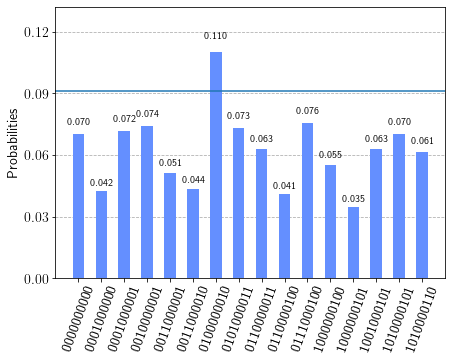

In [49]:
print(f"Example histogramm for modulo={modulo} and input state={hist_example_input} without uncomputation:")
hists[0]

Example histogramm for modulo=11 and input state=0 with uncomputation:


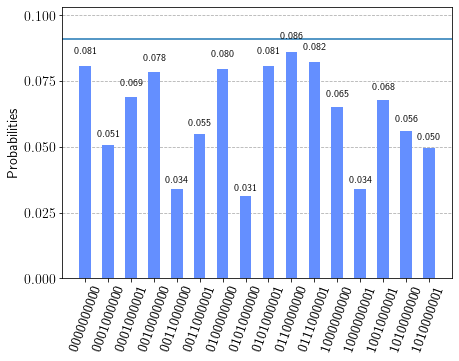

In [50]:
print(f"Example histogramm for modulo={modulo} and input state={hist_example_input} with uncomputation:")
hists[1]

# 3. Using AQFT as inverse QFT

Using the QFT proposed Kitaev in [Quantum measurements and the Abelian Stabilizer Problem (1995)](https://arxiv.org/abs/quant-ph/9511026) as an inverse QFT with a high probabilty of correctness requires uncomputing all qubits of the input state $|s\rangle$. For low $n$ this is very depth expensive, requiring an alternative. Using $AQFT_{uncomp}(M, \epsilon)^\dagger$ solves this issue, but since the remainder is not uncomputed completly and |$\hat s'\rangle$ only approximates $|\hat s\rangle$, there are still inaccuracies. Testing with $AQFT_{uncomp}(M, \epsilon)^\dagger |0\rangle \otimes |\hat s\rangle \otimes |0\rangle^{\max(2n'-2n+3, n_q+n+1)}$ for $s \in \mathbb{N^0}, s<M$, $|\hat s\rangle$ created with $FSC(M)$, seemingly creates the state $\alpha(s) |s\rangle + \beta(s) |s + c(M) \text{ mod } M\rangle$ with $c(M)\in \mathbb{N}$ constant with regards to $s$. Additionally the amplitudes and phases of $\alpha, \beta$ seem to be close $\forall s: \alpha(s) \approx \beta(s) \approx \frac{e^{i\theta(M)}}{\sqrt{2}}$, since measuring with $|S\rangle = (|s\rangle + |s+c(M) \text{ mod } M\rangle) / \sqrt{2}$ results in a state with probabilites $P(s) \approx 1/4, P(s+c(M) \text{ mod } M) \approx 1/2, P(s+2c(M) \text{ mod } M) \approx 1/4$. The tests were only performed for $2\leq M \leq11$ and may not be accurate for other ranges. For the use case in the QWOA mixer, the shift by performing the fourier transformation follwed by its inverse is not relevant since the only goal is mixing the states. Otherwise the shift could theoretically be uncomputed for $c(M) \neq M/2, M \text{ even }$, due to bijectivity.

Tests with example histograms. Warning: Long run time!

mod=2
mod=3
mod=4
mod=5
mod=6
mod=7
mod=8
mod=9
mod=10
mod=11
The shift constant for modulo=2 is 0
The shift constant for modulo=3 is 2
The shift constant for modulo=4 is 0
The shift constant for modulo=5 is 3
The shift constant for modulo=6 is 2
The shift constant for modulo=7 is 2
The shift constant for modulo=8 is 0
The shift constant for modulo=9 is 8
The shift constant for modulo=10 is 2
The shift constant for modulo=11 is 6

Measured 'uncomputed' state qubits for modulo=11, initial_state=7.


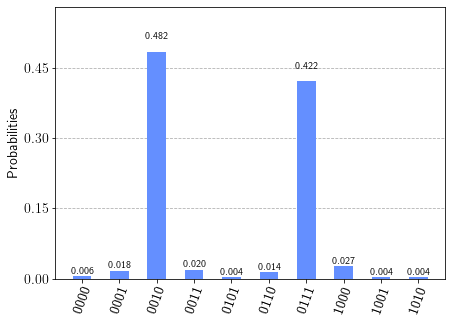

In [51]:
from library.distributions import UniformDistribution

hist_example_input = {"modulo": max(modulo, 11), "initial_state": max(initial_state, 7)}
state_to_cs = []
shots = 512

for mod in range(2, 12):
    print(f"mod={mod}")
    
    fsc = FSC(mod)
    aqft = AQFT(mod, uncompute_remainder=True, num_uc_precision_qubits=2, eps=6)
    num_rem_aux_qubits = aqft.num_remainder_qubits - fsc.num_state_qubits

    qr_state1 = QuantumRegister(fsc.num_state_qubits, "state1")
    qr_state2 = QuantumRegister(fsc.num_state_qubits, "state2")
    qr_ft = QuantumRegister(fsc.num_state_qubits, "ft")
    qr_aux = AncillaRegister(max(fsc.num_ancillas, aqft.num_ancillas + num_rem_aux_qubits), "aux")
    cr = ClassicalRegister(fsc.num_state_qubits, "cr")
    qc = QuantumCircuit(qr_state1, qr_state2, qr_ft, qr_aux, cr, name ="test")

    state_to_c = {}
    for test_state in range(mod):
        qc_test = qc.copy()
        for idx, bit in enumerate(reversed(bin(test_state)[2:])):
            if bit == "1":
                qc_test.x(idx)

        qc_test.append(fsc.to_gate(), 
                       qr_state1[:] + qr_ft[:] + qr_aux[:fsc.num_ancillas])
        qc_test.append(aqft.inverse().to_gate(), 
                       qr_state2[:] + qr_aux[:num_rem_aux_qubits] + qr_ft[:] +\
                       qr_aux[num_rem_aux_qubits: num_rem_aux_qubits + aqft.num_ancillas])
        qc_test.measure(qr_state2, cr)

        result_sim = backend_sim.run(transpile(qc_test, backend_sim), shots=shots).result()
        counts = result_sim.get_counts()
        filtered_counts = {key: counts[key] for key in counts if counts[key] > shots/6}
        state_strings = [key for key in filtered_counts]
                
        if len(filtered_counts) > 2:
            print(f"More than 2 main results counted for input state ({test_state}):", filtered_counts)
            state_to_c[test_state] = -1
        elif len(filtered_counts) == 1:
            if int(state_strings[0], 2) != test_state:
                print(f"Measured state is not input state ({test_state}):", filtered_counts)
                state_to_c[test_state] = -1
            else:
                state_to_c[test_state] = 0
        else:
            if abs(filtered_counts[state_strings[0]] - filtered_counts[state_strings[1]]) > shots/6:
                print(f"Amplitude difference to high for input state ({test_state}):", filtered_counts)
                state_to_c[test_state] = -1
            else:
                states = [int(state_string, 2) for state_string in state_strings]
                if states[0] != test_state and states[1] != test_state:
                    print(f"Measured states do not contain not input state ({test_state}):", filtered_counts)
                    state_to_c[test_state] = -1
                else:
                    if states[0] == test_state:
                        new_state = states[1]
                    else:
                        new_state = states[0]
                    
                    if new_state < test_state:
                        state_to_c[test_state] = new_state - test_state + mod
                    else:
                        state_to_c[test_state] = new_state - test_state                    
                
            
        if mod == hist_example_input["modulo"] and test_state == hist_example_input["initial_state"]:
            hist = plot_histogram(counts)
    state_to_cs.append(state_to_c)

mod_shift_constants = {}
for idx, mod in enumerate(range(2, 12)):
    shift_constants = list(set(state_to_cs[idx].values()))
    if len(shift_constants) != 1:
        print(f"No or multiple shift constants found for modulo={mod}:", state_to_cs[idx])
    else:
        mod_shift_constants[mod] = shift_constants[0]
        print(f"The shift constant for modulo={mod} is", shift_constants[0])

mod = hist_example_input["modulo"]
test_state = hist_example_input["initial_state"]
print()
print(f"Measured 'uncomputed' state qubits for modulo={mod}, initial_state={test_state}.")
hist.set_facecolor("white")
hist

In [52]:
# manual settings to compensate statistical errors 
mod_shift_constants[3] = 2

if len(mod_shift_constants) != 10:
    raise ValueError("Not all shift constants found, inspect manually.")

mod_shift_constants

{2: 0, 3: 2, 4: 0, 5: 3, 6: 2, 7: 2, 8: 0, 9: 8, 10: 2, 11: 6}

mod=2
Skipping case mod=2, shift constant is 0.
mod=3
Counts for mod=3, initial_state=0 agree with expectations: {'01': 142, '10': 226, '00': 144}
Counts for mod=3, initial_state=1 agree with expectations: {'10': 104, '00': 259, '01': 149}
Counts for mod=3, initial_state=2 agree with expectations: {'00': 131, '01': 249, '10': 132}
mod=4
Skipping case mod=4, shift constant is 0.
mod=5
Counts for mod=5, initial_state=0 agree with expectations: {'011': 214, '001': 126, '000': 140}
Counts for mod=5, initial_state=1 agree with expectations: {'100': 249, '001': 126, '010': 118}
Counts for mod=5, initial_state=2 agree with expectations: {'000': 223, '011': 137, '010': 128}
Counts for mod=5, initial_state=3 agree with expectations: {'001': 225, '011': 139, '100': 123}
Counts for mod=5, initial_state=4 agree with expectations: {'010': 221, '000': 128, '100': 139}
mod=6
Counts for mod=6, initial_state=0 agree with expectations: {'010': 211, '000': 107, '100': 97}
Counts for mod=6, initial_state=

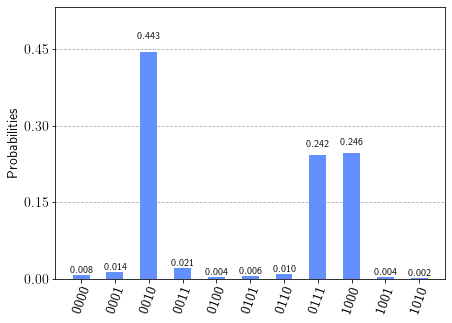

In [53]:
from library.adders import CnstHalfAdd, CtrlCnstHalfSub
from qiskit.circuit.library.arithmetic import IntegerComparator

for mod, shift_constant in mod_shift_constants.items():
    print(f"mod={mod}")
    if shift_constant == 0:
        print(f"Skipping case mod={mod}, shift constant is 0.")
        continue
        
    # fourier transforms
    fsc = FSC(mod)
    aqft = AQFT(mod, uncompute_remainder=True, num_uc_precision_qubits=2, eps=6)
    
    num_rem_aux_qubits = aqft.num_remainder_qubits - fsc.num_state_qubits

    qr_state1 = QuantumRegister(fsc.num_state_qubits, "state1")
    qr_state1_ext = AncillaRegister(1, "state1_ext")
    qr_cmp = AncillaRegister(1, "cmp")
    qr_state2 = QuantumRegister(fsc.num_state_qubits, "state2")
    qr_ft = QuantumRegister(fsc.num_state_qubits, "ft")
    qr_aux = AncillaRegister(max(fsc.num_ancillas, aqft.num_ancillas + num_rem_aux_qubits), "aux")
    cr = ClassicalRegister(fsc.num_state_qubits, "cr")
    qc = QuantumCircuit(qr_state1, qr_state1_ext, qr_cmp, qr_state2, qr_ft, qr_aux, cr, name ="test")

    state_to_c = {}
    for test_state in range(mod):
        qc_test = qc.copy()
        
        # create state (|0> + |c>)/sqrt(2)
        h_index = 0
        reduced_shift_constant = shift_constant
        while reduced_shift_constant % 2 == 0:
            reduced_shift_constant //= 2
            h_index += 1
        
        qc_test.h(h_index)
        if reduced_shift_constant > 1:
            reduced_shift_constant //= 2
            for idx, bit in enumerate(reversed(bin(reduced_shift_constant)[2:])):
                if bit == "1":
                    qc_test.cx(h_index, h_index + idx + 1)
                    
        if test_state > 0:
            # constant modular adder
            add = CnstHalfAdd(test_state, num_state_qubits=fsc.num_state_qubits, name=f"CtrlAdd(+{test_state})")
            int_cmp1 = IntegerComparator(fsc.num_state_qubits + 1, mod, name=f"IntCmp(>={mod})")
            ctrl_sub = CtrlCnstHalfSub(mod, num_state_qubits=fsc.num_state_qubits + 1, has_cout=False, name=f"CtrlSub(-{mod})")
            int_cmp2 = IntegerComparator(fsc.num_state_qubits, test_state, geq=False)
            
            qc_test.append(add.to_gate(), 
                           qr_aux[:add.num_ancillas] + qr_state1[:] + qr_state1_ext[:])
            qc_test.append(int_cmp1.to_gate(), 
                           qr_state1[:] + qr_state1_ext[:] + [qr_cmp[0]] + qr_aux[:int_cmp1.num_ancillas])
            qc_test.append(ctrl_sub.to_gate(),
                           qr_aux[:ctrl_sub.num_ancillas] + qr_state1[:] + qr_state1_ext[:] + [qr_cmp[0]])
            qc_test.append(int_cmp2.to_gate(), 
                           qr_state1[:] + [qr_cmp[0]] + qr_aux[:int_cmp2.num_ancillas])
        test_state2 = (test_state + shift_constant) % mod
        
        # fourier transforms
        qc_test.append(fsc.to_gate(), 
                       qr_state1[:] + qr_ft[:] + qr_aux[:fsc.num_ancillas])
        qc_test.append(aqft.inverse().to_gate(), 
                       qr_state2[:] + qr_aux[:num_rem_aux_qubits] + qr_ft[:] +\
                       qr_aux[num_rem_aux_qubits: num_rem_aux_qubits + aqft.num_ancillas])
        
        # measure
        qc_test.measure(qr_state2, cr)
        result_sim = backend_sim.run(transpile(qc_test, backend_sim), shots=shots).result()
        counts = result_sim.get_counts()
        filtered_counts = {key: counts[key] for key in counts if counts[key] > shots/8}
        state_strings = [key for key in filtered_counts]
        
        expected_counts = {bin_repr(test_state, pad_bits=fsc.num_state_qubits): int(shots/4), bin_repr(test_state2, pad_bits=fsc.num_state_qubits): int(shots/2)}
        expected_third_state = bin_repr((test_state2 + shift_constant) % mod, pad_bits=fsc.num_state_qubits)
        if expected_third_state in expected_counts:
            expected_counts[expected_third_state] += int(shots/4)
        else:
            expected_counts[expected_third_state] = int(shots/4)
            
        if len(filtered_counts) != len(expected_counts):
            print(f"Unexpected number of main states for mod={mod}, initial_state={test_state}:", filtered_counts)
        else:
            approx_equal = True
            for key in expected_counts:
                if abs(filtered_counts[key] - expected_counts[key]) > shots/8:
                    print(f"Counts deviate to much for mod={mod}, initial_state={test_state}, expected {expected_counts}, got:", filtered_counts)
                    approx_equal = False
            if approx_equal:
                print(f"Counts for mod={mod}, initial_state={test_state} agree with expectations:", filtered_counts)
            
        if mod == hist_example_input["modulo"] and test_state == hist_example_input["initial_state"]:
            hist = plot_histogram(counts)
    state_to_cs.append(state_to_c)

mod = hist_example_input["modulo"]
test_state = hist_example_input["initial_state"]
print()
print(f"Measured 'uncomputed' state qubits for modulo={mod}, shift={mod_shift_constants[mod]}, initial_state=(|{test_state}> + |{(test_state + mod_shift_constants[mod]) % mod}>)/√2.")
hist.set_facecolor("white")
hist